# 一、快速上手

本文将以训练 FashionMNIST 数据集为例，简单地介绍如何使用 OneFlow 完成深度学习中的常见任务。通过文章中的链接可以跳转到各个子任务的专题介绍。

详细的介绍请阅读本文。让我们先从导入必要的库开始：

[FlowVision](https://github.com/Oneflow-Inc/vision) 是与 OneFlow 配套的、专用于计算机视觉任务的工具库，包含诸多模型、数据增强方法、数据变换操作、数据集等。我们在这里导入并使用 FlowVision 提供的数据变换模块 `transforms` 和数据集模块 `datasets`。可以通过下面的命令安装：

In [39]:
!pip install flowvision==0.0.54

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [40]:
import oneflow as flow
import oneflow.nn as nn
from flowvision import transforms
from flowvision import datasets

设置 batch size 以及运行设备：

In [41]:
BATCH_SIZE=64
DEVICE = "cuda"
print("Using {} device".format(DEVICE))

Using cuda device


## 加载数据

OneFlow 可以使用 [Dataset 与 DataLoader](https://oneflow.cloud/drill/#/project/private/code?id=f7ae0d7f33564b2add5b51fffe81c19e&workspaceId) 加载数据。

[flowvision.datasets](https://flowvision.readthedocs.io/en/stable/flowvision.datasets.html) 模块中包含了不少真实的数据集(如 MNIST、CIFAR10、FashionMNIST)。

我们通过 `flowvision.vision.datasets.FashionMNIST` 获取 FashionMNIST 的训练集和测试集数据。

In [42]:
#训练数据
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    # 变换图像数据为tensor
    transform=transforms.ToTensor(),
    download=True,
    source_url="https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/",

)
#测试数据
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=transforms.ToTensor(),
    download=True,
    source_url="https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/",
)

输出：

```text
Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to data_fashion2/FashionMNIST/raw/train-images-idx3-ubyte.gz
26422272/? [00:47<00:00, 679825.75it/s]
Extracting data_fashion2/FashionMNIST/raw/train-images-idx3-ubyte.gz to data_fashion2/FashionMNIST/raw
...
```

数据集下载并解压到 `./data` 目录下。

利用 [oneflow.utils.data.DataLoader](https://oneflow.readthedocs.io/en/master/utils.html#oneflow.utils.data.DataLoader) 可以将 `dataset` 封装为迭代器，方便后续训练。

In [43]:
#flow.utils.data.DataLoader的用法在技术文档有详细说明：https://oneflow.readthedocs.io/en/master/utils.html
# BATCH_SIZE表示样本数量，shuffle=True表示对数据进行洗牌
train_dataloader = flow.utils.data.DataLoader(
    training_data, BATCH_SIZE, shuffle=True
)
test_dataloader = flow.utils.data.DataLoader(
    test_data, BATCH_SIZE, shuffle=False
)

for x, y in train_dataloader:
    print("x.shape:", x.shape)
    print("y.shape:", y.shape)
    break

x.shape: oneflow.Size([64, 1, 28, 28])
y.shape: oneflow.Size([64])


输出：

```text
x.shape: flow.Size([64, 1, 28, 28])
y.shape: flow.Size([64])
```
> [Dataset 与 Dataloader](https://oneflow.cloud/drill/#/project/private/code?id=f7ae0d7f33564b2add5b51fffe81c19e&workspaceId)

## 搭建网络

想要搭建网络，只需要实现一个继承自 `nn.Module` 的类就可以了。在它的 `__init__` 方法中定义神经网络的结构，在它的 `forward` 方法中指定前向传播的计算逻辑。

In [44]:
#通过子类化 nn.Module定义我们的神经网络，用__init__方法初始化神经网络层,每一个 nn.Module子类用forward正向传播方法实现对输入数据的操作
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),#nn.Linear()设置网络中的全连接层,两个参数是对输入张量和输出张量的设置
            nn.ReLU(),#将输入小于0的值幅值为0，输入大于0的值不变,技术文档地址：https://oneflow.readthedocs.io/en/master/nn.html
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x) #flatten()对多维数据进行降维
        logits = self.linear_relu_stack(x)
        return logits
#创建一个实例（对象），把它放到DEVICE上
model = NeuralNetwork().to(DEVICE)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


输出：

```text
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
```

> [搭建神经网络](https://oneflow.cloud/drill/#/project/private/code?id=7e351fbd41fef653f26078e91915e76d&workspaceId)

## 训练模型

为了训练模型，我们需要损失函数 `loss_fn` 和优化器 `optimizer`，损失函数用于评价神经网络预测的结果与 label 的差距；`optimizer` 调整网络的参数，使得网络预测的结果越来越接近 label（标准答案），这里选用 [oneflow.optim.SGD](https://oneflow.readthedocs.io/en/master/optim.html?highlight=optim.SGD#oneflow.optim.SGD)。这一过程被称为反向传播。

In [45]:
loss_fn = nn.CrossEntropyLoss().to(DEVICE)#交叉熵损失函数
optimizer = flow.optim.SGD(model.parameters(), lr=1e-3)

定义一个 `train` 函数进行训练，完成前向传播、计算 loss、反向传播更新模型参数等工作。

In [46]:
def train(iter, model, loss_fn, optimizer):
    size = len(iter.dataset)
    for batch, (x, y) in enumerate(iter):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current = batch * BATCH_SIZE
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

同时，定义一个 `test` 函数，用于检验模型的精度：

In [47]:
def test(iter, model, loss_fn):
    size = len(iter.dataset)
    num_batches = len(iter)
    model.eval()
    test_loss, correct = 0, 0
    with flow.no_grad():
        for x, y in iter:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            pred = model(x)
            test_loss += loss_fn(pred, y)
            bool_value = (pred.argmax(1).to(dtype=flow.int64)==y)
            correct += float(bool_value.sum().numpy())
    test_loss /= num_batches
    print("test_loss", test_loss, "num_batches ", num_batches)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}, Avg loss: {test_loss:>8f}")

然后可以开始训练，定义5轮 epoch，每训练完一个 epoch 都使用 `test` 来评估一下网络的精度：

In [48]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.294746  [    0/60000]
loss: 2.283025  [ 6400/60000]
loss: 2.256728  [12800/60000]
loss: 2.256682  [19200/60000]
loss: 2.241470  [25600/60000]
loss: 2.224264  [32000/60000]
loss: 2.204131  [38400/60000]
loss: 2.197441  [44800/60000]
loss: 2.154429  [51200/60000]
loss: 2.137798  [57600/60000]
test_loss tensor(2.1481, device='cuda:0', dtype=oneflow.float32) num_batches  157
Test Error: 
 Accuracy: 44.0, Avg loss: 2.148141
Epoch 2
-------------------------------
loss: 2.135089  [    0/60000]
loss: 2.147892  [ 6400/60000]
loss: 2.076566  [12800/60000]
loss: 2.055215  [19200/60000]
loss: 2.028604  [25600/60000]
loss: 2.045242  [32000/60000]
loss: 1.980073  [38400/60000]
loss: 1.965189  [44800/60000]
loss: 1.937590  [51200/60000]
loss: 1.887024  [57600/60000]
test_loss tensor(1.8685, device='cuda:0', dtype=oneflow.float32) num_batches  157
Test Error: 
 Accuracy: 56.0, Avg loss: 1.868529
Epoch 3
-------------------------------
loss: 1.835631  [ 

输出：

```text
Epoch 1
-------------------------------
loss: 2.152148  [    0/60000]
loss: 2.140148  [ 6400/60000]
loss: 2.147773  [12800/60000]
loss: 2.088032  [19200/60000]
loss: 2.074728  [25600/60000]
loss: 2.034325  [32000/60000]
loss: 1.994112  [38400/60000]
loss: 1.984397  [44800/60000]
loss: 1.918280  [51200/60000]
loss: 1.884574  [57600/60000]
test_loss tensor(1.9015, device='cuda:0', dtype=oneflow.float32) num_batches  157
Test Error: 
 Accuracy: 56.3, Avg loss: 1.901461
Epoch 2
-------------------------------
loss: 1.914766  [    0/60000]
loss: 1.817333  [ 6400/60000]
loss: 1.835239  [12800/60000]
...
```
> [自动求梯度](https://oneflow.cloud/drill/#/project/private/code?id=d05f6d1ec8e587456389b95270d3b7ac&workspaceId=d05f6d1ec8e587456389b95270d3b7ac)
> [反向传播与 optimizer](https://oneflow.cloud/drill/#/project/private/code?id=1a377e1aa82311b64e70473ec34aba85&workspaceId)

## 保存与加载模型

调用 [oneflow.save](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.save#oneflow.save) 可以保存模型。保存的模型可以通过 [oneflow.load](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.load#oneflow.load) 加载，用于预测等工作。

In [ ]:
flow.save(model.state_dict(), "./model")

> [模型的加载与保存](https://oneflow.cloud/drill/#/project/private/code?id=1ce7600d419d1a609678c547cf1a9856&workspaceId=1ce7600d419d1a609678c547cf1a9856)

## 交流 QQ 群

安装或使用过程遇到问题，欢迎入群与众多 OneFlow 爱好者共同讨论交流：

加 QQ 群 **331883** 或扫描二维码

![OneFlow 技术交流](./imgs/qq_group.png)

# 二、Tensor 张量

神经网络中的数据，都存放在 Tensor 中，Tensor 类似多维数组或者数学上的矩阵。OneFlow 提供了很多用于操作 Tensor 的算子，Tensor 与算子一起构成神经网络。

Tensor 有别于普通的多维数组的地方是：除了可以运行在 CPU 上外，它还可以运行在 其它 AI 芯片（如 NVIDIA GPU）上，因此可以提高运算速度。此外，OneFlow 还为张量提供了 [自动求导](https://oneflow.cloud/drill/#/project/private/code?id=d05f6d1ec8e587456389b95270d3b7ac&workspaceId=d05f6d1ec8e587456389b95270d3b7ac
) 的功能。

In [49]:
import oneflow as flow
import numpy as np

## 创建 Tensor
有多种方法创建 Tensor，包括：

- 直接从数据创建
- 通过 Numpy 数组创建
- 使用算子创建

### 直接从数据创建
可以直接从数据创建 Tensor：

In [52]:
x1 = flow.tensor([[1, 2], [3, 4]])
x2 = flow.tensor([[1.0, 2.0], [3.0, 4.0]])
print(x1)
print(x2)

tensor([[1, 2],
        [3, 4]], dtype=oneflow.int64)
tensor([[1., 2.],
        [3., 4.]], dtype=oneflow.float32)


可以看到创建的 `x1`、`x2` Tensor，它们的类型分别是 `int64` 和 `float32`。

```text
tensor([[1, 2],
        [3, 4]], dtype=oneflow.int64)
tensor([[1., 2.],
        [3., 4.]], dtype=oneflow.float32)
```

### 通过 Numpy 数组创建

Tensor 可以通过 Numpy 数组创建，只需要在创建 Tensor 对象时，将 Numpy 数组作为参数传递即可。

In [56]:
x3 = flow.tensor(np.ones((2,3)))
x4 = flow.tensor(np.random.rand(2,3))#生成服从"0~1"均匀分布的随机数,范围是[0,1)
print(x3)
print(x4)

tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=oneflow.float64)
tensor([[0.3094, 0.7261, 0.0591],
        [0.8024, 0.0231, 0.3863]], dtype=oneflow.float64)


```text
tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=oneflow.float64)
tensor([[0.6213, 0.6142, 0.1592],
        [0.5539, 0.8453, 0.8576]], dtype=oneflow.float64)
```

### 通过算子创建

OneFlow 中还提供了一些算子，可以通过它们创建 Tensor。比如 [ones](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.ones#oneflow.ones)、 [zeros](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.zeros#oneflow.zeros),、[eye](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.eye#oneflow.eye)，它们分别创建全为1的张量、全为0的张量和单位张量。

In [58]:
x5 = flow.ones(2, 3)
x6 = flow.zeros(2, 3)
x7 = flow.eye(3)
print(x5)
print(x6)
print(x7)

tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=oneflow.float32)
tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=oneflow.float32)
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=oneflow.float32)


```text
tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=oneflow.float32)
tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=oneflow.float32)
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=oneflow.float32)
```

[randn](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.randn#oneflow.randn) 方法可以创建随机化的张量：

In [59]:
x8 = flow.randn(2,3)
print(x8)

tensor([[ 0.4458, -1.1573, -1.8464],
        [-0.0031,  0.4284,  0.8948]], dtype=oneflow.float32)


## `Tensor` 与 `tensor` 的区别
细心的用户会发现，OneFlow 中有 [oneflow.Tensor](https://oneflow.readthedocs.io/en/master/tensor.html?highlight=oneflow.Tensor#oneflow.Tensor) 和 [oneflow.tensor](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.Tensor#oneflow.tensor) 两个接口，它们都能用来创建张量。那么它们有什么区别呢？

简单而言，大写的 `Tensor` 数据类型默认限定为 `float32`，而小写的 `tensor` 的数据类型可以随着创建时的数据改变。以下代码展示了两者这方面的区别：

In [60]:
print(flow.Tensor([1, 2, 3]))
print(flow.tensor([1, 2, 3]))
print(flow.tensor([1.0, 2.0, 3.0]))

tensor([1., 2., 3.], dtype=oneflow.float32)
tensor([1, 2, 3], dtype=oneflow.int64)
tensor([1., 2., 3.], dtype=oneflow.float32)


数据结果为：

```text
tensor([1., 2., 3.], dtype=oneflow.float32)
tensor([1, 2, 3], dtype=oneflow.int64)
tensor([1., 2., 3.], dtype=oneflow.float32)
```

此外，大写的 `Tensor` 可以在创建时不指定具体数据：

In [64]:
x9 = flow.Tensor(2, 3)
print(x9.shape)

oneflow.Size([2, 3])


oneflow.Size([2, 3])  
因此，如果在创建张量的同时不想指定数据，那么常常用 `oneflow.Tensor`，否则，应该使用 `oneflow.tensor`。

## Tensor 的属性

Tensor 的 `shape`、`dtype`、`device` 属性分别描述了 Tensor 的形状、数据类型和所在的设备类型。

In [65]:
x9 = flow.randn(1,4)
print(x9.shape)
print(x9.dtype)
print(x9.device)

oneflow.Size([1, 4])
oneflow.float32
cpu:0


输出结果分别展示了张量的形状、数据类型和所处的设备（第0号 CPU 上，之所以有编号，是因为 OneFlow 很方便自然地支持分布式，可参考 [Consistent Tensor](../parallelism/03_consistent_tensor.md)）

```text
oneflow.Size([1, 4])
oneflow.float32
cpu:0
```

可以通过 [reshape](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.reshape#oneflow.reshape) 方法改变 Tensor 的形状，用 [to](https://oneflow.readthedocs.io/en/master/tensor.html?highlight=Tensor.to#oneflow.Tensor.to) 方法改变 Tensor 的数据类型和所处设备：

```
x10 = x9.reshape(2, 2)
x11 = x10.to(dtype=flow.int32, device=flow.device("cuda"))
print(x10.shape)
print(x11.dtype, x11.device)
```

```text
oneflow.Size([2, 2])
oneflow.int32 cuda:0
```

## 操作 Tensor 的常见算子

OneFlow 中提供了大量的算子，对 Tensor 进行操作，它们大多在 [oneflow](https://oneflow.readthedocs.io/en/master/oneflow.html)、[oneflow.Tensor](https://oneflow.readthedocs.io/en/master/tensor.html)、[oneflow.nn](https://oneflow.readthedocs.io/en/master/nn.html)、[oneflow.nn.functional](https://oneflow.readthedocs.io/en/master/functional.html)这几个名称空间下。

OneFlow 中的 Tensor，与 Numpy 数组一样易用。比如，支持与 Numpy 类似的切片操作：

In [66]:
tensor = flow.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])
print('Last column:', tensor[..., -1])
tensor[:,1] = 0 #将第1列元素设为0，列号从0开始
print(tensor)

First row:  tensor([1., 1., 1., 1.], dtype=oneflow.float32)
First column:  tensor([1., 1., 1., 1.], dtype=oneflow.float32)
Last column: tensor([1., 1., 1., 1.], dtype=oneflow.float32)
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]], dtype=oneflow.float32)


```text
First row:  tensor([1., 1., 1., 1.], dtype=oneflow.float32)
First column:  tensor([1., 1., 1., 1.], dtype=oneflow.float32)
Last column: tensor([1., 1., 1., 1.], dtype=oneflow.float32)
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]], dtype=oneflow.float32)
```

此外，OneFlow 中还有很多其它操作，如算数相关操作的 [add](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.add#oneflow.add)、[sub](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.sub#oneflow.sub)、[mul](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.mul#oneflow.mul)、[div](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.div#oneflow.div)等；位置相关操作的 [scatter](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.scatter#oneflow.scatter)、[gather](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.gather#oneflow.gather)、[gather_nd](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.gather_nd#oneflow.gather_nd)等；以及激活函数、卷积等（[relu](https://oneflow.readthedocs.io/en/master/functional.html?highlight=oneflow.relu#oneflow.nn.functional.relu)、[conv2d](https://oneflow.readthedocs.io/en/master/functional.html?highlight=oneflow.conv2d#oneflow.nn.functional.conv2d)），点击它们的链接可以查看更详细的 API 说明，并找到更多的其它算子。

# 三、Dataset 与 DataLoader

OneFlow 的 `Dataset` 与 `DataLoader` 的行为与 [PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 的是一致的，都是为了让数据集管理与模型训练解耦。

`Dataset` 类用于定义如何读取数据。对于常见的计算机视觉数据集（如 FashionMNIST），可以直接使用 [FlowVision](https://github.com/Oneflow-Inc/vision) 库的 `datasets` 模块提供的数据集类，可以帮助我们自动下载并加载一些流行的数据集，这些类都间接继承了 `Dataset` 类。对于其他数据集，可以通过继承 `Dataset` 类来自定义数据集类。

`DataLoader` 将 `Dataset` 封装为迭代器，方便训练时遍历并操作数据。

In [68]:
!pip install flowvision==0.0.54

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [69]:
import matplotlib.pyplot as plt

import oneflow as flow
import oneflow.nn as nn
from oneflow.utils.data import Dataset
from flowvision import datasets
from flowvision import transforms

上面导入的 [flowvision.transforms](https://flowvision.readthedocs.io/en/stable/flowvision.transforms.html) 提供了一些对图像数据进行变换的操作（如 `ToTensor` 可以将 PIL 图像或 NumPy 数组转换为张量），可以在数据集类中直接使用。

## 使用 FlowVision 加载数据集

以下的例子展示了如何使用 `flowvision.datasets` 加载 FashionMNIST 数据集。

我们向 `FashionMNIST` 类传入以下参数：
- `root`：数据集存放的路径
- `train`： `True` 代表下载训练集、`False` 代表下载测试集
- `download=True`： 如果 `root` 路径下数据集不存在，则从网络下载
- `transforms`：指定的数据转换方式


In [72]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    source_url="https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/",
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    source_url="https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/",
)

第一次运行，会下载数据集，输出：

```text
Downloading https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/train-images-idx3-ubyte.gz
Downloading https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/train-images-idx3-ubyte.gz to data/FashionMNIST/raw/train-images-idx3-ubyte.gz
26422272/? [00:02<00:00, 8090800.72it/s]
Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw

Downloading https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/train-labels-idx1-ubyte.gz
Downloading https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
29696/? [00:00<00:00, 806948.09it/s]
Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Downloading https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/t10k-images-idx3-ubyte.gz
Downloading https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
4422656/? [00:00<00:00, 19237994.98it/s]
Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw

Downloading https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/t10k-labels-idx1-ubyte.gz
Downloading https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/mnist/Fashion-MNIST/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
6144/? [00:00<00:00, 152710.85it/s]
Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
```

## 遍历数据

`Dataset` 对象，可以像 `list` 一样，用下表索引，比如 `training_data[index]`。
以下的例子，随机访问 `training_data` 中的9个图片，并显示。

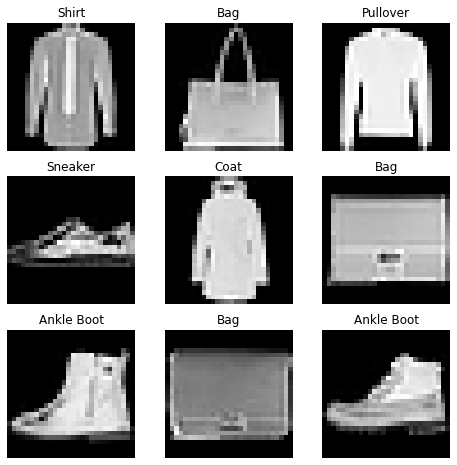

In [73]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
from random import randint
for i in range(1, cols * rows + 1):
    sample_idx = randint(0, len(training_data))
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap="gray")
plt.show()

![fashionMNIST](./imgs/fashionMNIST.png)

## 自定义 Dataset

通过继承 [oneflow.utils.data.Dataset](https://oneflow.readthedocs.io/en/master/utils.html?highlight=oneflow.utils.data.Dataset#oneflow.utils.data.Dataset) 可以实现自定义 `Dataset`，自定义 `Dataset` 同样可以配合下一节介绍的 `Dataloader` 使用，简化数据处理的流程。

以下的例子展示了如何实现一个自定义 `Dataset`，它的关键步骤是：

- 继承 `oneflow.utils.data.Dataset`
- 实现类的 `__len__` 方法，返回结果通常为该数据集中的样本数量
- 实现类的 `__getitem__` 方法，它的返回值对应了用户（或框架）调用 `dataset_obj[idx]` 时得到的结果

In [76]:
import numpy as np
class CustomDataset(Dataset):
    raw_data_x = np.array([[1, 2], [2, 3], [4, 6], [3, 1]], dtype=np.float32)
    raw_label = np.array([[8], [13], [26], [9]], dtype=np.float32)

    def __init__(self, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(raw_label)

    def __getitem__(self, idx):
        x = CustomDataset.raw_data_x[idx]
        label = CustomDataset.raw_label[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            label = self.target_transform(label)
        return x, label

custom_dataset = CustomDataset()
print(custom_dataset[0])
print(custom_dataset[1])

(array([1., 2.], dtype=float32), array([8.], dtype=float32))
(array([2., 3.], dtype=float32), array([13.], dtype=float32))


输出：

```text
(array([1., 2.], dtype=float32), array([8.], dtype=float32))
(array([2., 3.], dtype=float32), array([13.], dtype=float32))
```

## 使用 DataLoader

利用 Dataset 可以一次获取到所有数据。但是在训练中，往往有其它的需求，如：一次读取 batch size 份数据；1轮 epoch 训练后，数据重新打乱（reshuffle）等。

这时候，使用 `DataLoader` 即可。 `DataLoader` 可以将 `Dataset` 封装为迭代器，方便训练循环中获取数据。如以下例子：

- `batch_size=64` ： 指定一次迭代返回的数据 batch size
- `shuffle` ：是否要随机打乱数据的顺序

In [86]:
from oneflow.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
#next() 返回迭代器的下一个项目，iter() 函数生成迭代器
x, label = next(iter(train_dataloader))
print(f"shape of x:{x.shape}, shape of label: {label.shape}")

shape of x:oneflow.Size([64, 1, 28, 28]), shape of label: oneflow.Size([64])


输出：
```text
shape of x:oneflow.Size([64, 1, 28, 28]), shape of label: oneflow.Size([64])
```

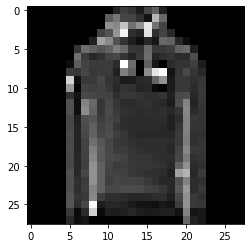

tensor(2, dtype=oneflow.int64)


In [87]:
img = x[0].squeeze().numpy()
label = label[0]
plt.imshow(img, cmap="gray")
plt.show()
print(label)

输出：（随机输出一张图片）

![dataloader item](./imgs/dataloader_item.png)

```text
tensor(9, dtype=oneflow.int64)
```

自然我们也可以在训练的循环中，使用 `DataLoader` 迭代器：

In [89]:
for x, label in train_dataloader:
    print(x.shape, label.shape)
    # training...

oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1,

oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1,

oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1,

oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1,

oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1,

oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1, 28, 28]) oneflow.Size([64])
oneflow.Size([64, 1,

# 四、搭建神经网络

​神经网络的各层，可以使用 [oneflow.nn](https://oneflow.readthedocs.io/en/master/nn.html) 名称空间下的 API 搭建，它提供了构建神经网络所需的常见 Module（如 [oneflow.nn.Conv2d](https://oneflow.readthedocs.io/en/master/nn.html?highlight=oneflow.nn.Conv2D#oneflow.nn.Conv2d)，[oneflow.nn.ReLU](https://oneflow.readthedocs.io/en/master/nn.html?highlight=oneflow.nn.ReLU#oneflow.nn.ReLU) 等等）。 用于搭建网络的所有 Module 类都继承自 [oneflow.nn.Module](https://oneflow.readthedocs.io/en/master/module.html#oneflow.nn.Module)，多个简单的 Module 可以组合在一起构成更复杂的 Module，用这种方式，用户可以轻松地搭建和管理复杂的神经网络。

In [90]:
import oneflow as flow
import oneflow.nn as nn

## 定义 Module 类

`oneflow.nn` 下提供了常见的 Module 类，我们可以直接使用它们，或者在它们的基础上，通过自定义 Module 类搭建神经网络。搭建过程包括：

- 写一个继承自 `oneflow.nn.Module` 的类
- 实现类的 `__init__` 方法，在其中构建神经网络的结构
- 实现类的 `forward` 方法，这个方法针对 Module 的输入进行计算

In [91]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
net = NeuralNetwork()
print(net)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


以上代码，会输出刚刚搭建的 `NeuralNetwork` 网络的结构：

```text
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)
```

接着，调用 `net` （注意：不推荐显式调用 `forward`）即可完成前向传播：

In [92]:
X = flow.ones(1, 28, 28)
logits = net(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3], dtype=oneflow.int64)


会得到类似以下的输出结果：

```text
Predicted class: tensor([1], dtype=oneflow.int32)
```

以上从数据输入、到网络计算，最终推理输出的流程，如下图所示：

![todo](./imgs/neural-network-layers.png)

## `flow.nn.functional`

除了 `oneflow.nn` 外，[oneflow.nn.functional](https://oneflow.readthedocs.io/en/master/functional.html) 名称空间下也提供了不少 API。它与 `oneflow.nn` 在功能上有一定的重叠。比如 [nn.functional.relu](https://oneflow.readthedocs.io/en/master/functional.html?highlight=relu#oneflow.nn.functional.relu) 与 [nn.ReLU](https://oneflow.readthedocs.io/en/master/nn.html?highlight=relu#oneflow.nn.ReLU) 都可用于神经网络做 activation 操作。

两者的区别主要有：

- `nn` 下的 API 是类，需要先构造实例化对象，再调用；`nn.functional` 下的 API 是作为函数直接调用
- `nn` 下的类内部自己管理了网络参数；而 `nn.functional` 下的函数，需要我们自己定义参数，每次调用时手动传入

实际上，OneFlow 提供的大部分 Module 是通过封装 `nn.functional` 下的方法得到的。`nn.functional` 提供了更加细粒度管理网络的可能。 

以下的例子，使用 `nn.functional` 中的方法，构建与上文中 `NeuralNetwork` 类等价的 Module `FunctionalNeuralNetwork`，读者可以体会两者的异同：

In [94]:
class FunctionalNeuralNetwork(nn.Module):    
    def __init__(self):
        super(FunctionalNeuralNetwork, self).__init__()
        
        self.weight1 = nn.Parameter(flow.randn(28*28, 512))
        self.bias1 = nn.Parameter(flow.randn(512))

        self.weight2 = nn.Parameter(flow.randn(512, 512))
        self.bias2 = nn.Parameter(flow.randn(512))

        self.weight3 = nn.Parameter(flow.randn(512, 10))
        self.bias3 = nn.Parameter(flow.randn(10))
        
    def forward(self, x):
        x = x.reshape(1, 28*28)
        out = flow.matmul(x, self.weight1)#.matmul()是矩阵的乘法，矩阵的行和列对应相乘求和。
        out = out + self.bias1
        out = nn.functional.relu(out)

        out = flow.matmul(out, self.weight2)
        out = out + self.bias2
        out = nn.functional.relu(out)

        out = flow.matmul(out, self.weight3)
        out = out + self.bias3
        out = nn.functional.relu(out)

        return out

net = FunctionalNeuralNetwork()
X = flow.ones(1, 28, 28)
logits = net(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([7], dtype=oneflow.int64)


## Module 容器

比较以上 `NeuralNetwork` 与 `FunctionalNeuralNetwork` 实现的异同，可以发现 [nn.Sequential](https://oneflow.readthedocs.io/en/master/nn.html?highlight=nn.Sequential#oneflow.nn.Sequential) 对于简化代码起到了重要作用。

`nn.Sequential` 是一种特殊容器，只要是继承自 `nn.Module` 的类都可以放置放置到其中。

它的特殊之处在于：当 Sequential 进行前向传播时，Sequential 会自动地将容器中包含的各层“串联”起来。具体来说，会按照各层加入 Sequential 的顺序，自动地将上一层的输出，作为下一层的输入传递，直到得到整个 Module 的最后一层的输出。

以下是不使用 Sequential 构建网络的例子（不推荐）：

In [97]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(20,64,5)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        return out

如果使用 Sequential，则看起来是这样，会显得更简洁。

In [99]:
class MySeqModel(nn.Module):
    def __init__(self):
        super(MySeqModel, self).__init__()
        self.seq = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )

    def forward(self, x):
        return self.seq(x)

除了 Sequential 外，还有 `nn.Modulelist` 及 `nn.ModuleDict`，除了会自动注册参数到整个网络外，他们的其它行为类似 Python list、Python dict，只是常用简单的容器，不会自动进行前后层的前向传播，需要自己手工遍历完成各层的计算。 

# 五、Autograd

神经网络的训练过程离不开 **反向传播算法**，在反向传播过程中，需要获取 loss 函数对模型参数的梯度，用于更新参数。

OneFlow 提供了自动求导机制，可自动计算神经网络中参数的梯度。

本文将先介绍计算图的基本概念，它有利于理解 OneFlow 自动求导的常见设置及限制，再介绍 OneFlow 中与自动求导有关的常见接口。

## 计算图

张量与算子，共同组成计算图，如以下代码：

In [103]:
import oneflow as flow

def loss(y_pred, y):
    return flow.sum(1/2*(y_pred-y)**2)

x = flow.ones(1, 5)  # 输入
w = flow.randn(5, 3, requires_grad=True)#requires_grad说明当前量是否需要在计算中保留对应的梯度信息
b = flow.randn(1, 3, requires_grad=True)
z = flow.matmul(x, w) + b

y = flow.zeros(1, 3)  # label
l = loss(z,y)

它对应的计算图如下：

![todo](./imgs/compute_graph.png)

计算图中，像 `x`、`w`、`b`、`y` 这种只有输出，没有输入的节点称为 **叶子节点**；像 `loss` 这种只有输入没有输出的节点，称为 **根节点**。

反向传播过程中，需要求得 `l` 对 `w`、`b` 的梯度，以更新这两个模型参数。因此，我们在创建它们时，设置 `requires_grad` 为 `True`。

## 自动求梯度

### backward 与梯度

在反向传播的过程中，需要得到 `l` 分别对 `w`、`b` 的梯度 $\frac{\partial l}{\partial w}$ 和 $\frac{\partial l}{\partial b}$。我们只需要对 `l` 调用 `backward()` 方法，然后 OneFlow 就会自动计算梯度，并且存放到 `w` 与 `b` 的 `grad` 成员中。

In [104]:
l.backward()
print(w.grad)
print(b.grad)

tensor([[-1.7841, -2.3939,  3.6692],
        [-1.7841, -2.3939,  3.6692],
        [-1.7841, -2.3939,  3.6692],
        [-1.7841, -2.3939,  3.6692],
        [-1.7841, -2.3939,  3.6692]], dtype=oneflow.float32)
tensor([[-1.7841, -2.3939,  3.6692]], dtype=oneflow.float32)


```text
tensor([[0.9397, 2.5428, 2.5377],
        [0.9397, 2.5428, 2.5377],
        [0.9397, 2.5428, 2.5377],
        [0.9397, 2.5428, 2.5377],
        [0.9397, 2.5428, 2.5377]], dtype=oneflow.float32)
tensor([[0.9397, 2.5428, 2.5377]], dtype=oneflow.float32)
```

### 对非叶子节点求梯度
默认情况下，只有 `requires_grad=True` 的叶子节点的梯度会被保留。非叶子节点的 `grad` 属性默认在 `backward` 执行过程中，会自动释放，不能查看。

如果想保留并查看非叶子节点的梯度，可以调用 `Tensor.retain_grad` 方法：

In [108]:
from math import pi
n1 = flow.tensor(pi/2, requires_grad=True)
n2 = flow.sin(n1)
n2.retain_grad()
n3 = flow.pow(n2, 2)

n3.backward()
print(n1.grad)
print(n2.grad)

tensor(-8.7423e-08, dtype=oneflow.float32)
tensor(2., dtype=oneflow.float32)


以上代码，既求 $\frac{\partial n_3}{\partial n_1}$，也求 $\frac{\partial n_3}{\partial n_2}$

输出:

```
tensor(-8.7423e-08, dtype=oneflow.float32)
tensor(2., dtype=oneflow.float32)
```

### 对一个计算图多次 `backward()`
默认情况下，对于给定的计算图，只能调用 `backward()` 一次。比如，以下代码会报错：

In [109]:
n1 = flow.tensor(10., requires_grad=True)
n2 = flow.pow(n1, 2)
n2.backward()
n2.backward()

CheckFailedException: 
  File "/home/ci-user/runners/release/_work/oneflow/oneflow/oneflow/api/python/autograd/autograd.cpp", line 81, in Backward
    one::GetThreadLocalAutogradEngine()->RunBackwardAndSaveGrads4LeafTensorIf( outputs, *gradients, retain_graph, create_graph)
  File "/home/ci-user/runners/release/_work/oneflow/oneflow/oneflow/core/autograd/autograd_engine.cpp", line 456, in RunBackwardAndSaveGrads4LeafTensor
    graph_task.Apply( true)
  File "/home/ci-user/runners/release/_work/oneflow/oneflow/oneflow/core/autograd/autograd_engine.cpp", line 432, in Apply
    node->Apply(create_graph_)
  File "/home/ci-user/runners/release/_work/oneflow/oneflow/oneflow/core/autograd/autograd_engine.cpp", line 178, in Apply
    Check failed: backward_fn_.get() != nullptr This FunctionNode with name `scalar_pow_backward` has been released.
Maybe you try to backward through the node a second time. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

报错信息：

> Maybe you try to backward through the node a second time. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

如果想要在同一个计算图上调用多次 `backward()`，需要在调用时设置 `retain_graph=True`。

In [110]:
n1 = flow.tensor(10., requires_grad=True)
n2 = flow.pow(n1, 2)

n2.backward(retain_graph=True)
print(n1.grad)
n2.backward()
print(n1.grad)

tensor(20., dtype=oneflow.float32)
tensor(40., dtype=oneflow.float32)


输出：

```text
tensor(20., dtype=oneflow.float32)
tensor(40., dtype=oneflow.float32)
```

以上输出可知，OneFlow 会 **累加** 多次 `backward()` 计算得到的梯度。
如果想清空梯度，可以调用 `zeros_` 方法：

In [111]:
n1 = flow.tensor(10., requires_grad=True)
n2 = flow.pow(n1, 2)

n2.backward(retain_graph=True)
print(n1.grad)
n1.grad.zeros_()
n2.backward()
print(n1.grad)

tensor(20., dtype=oneflow.float32)
tensor(20., dtype=oneflow.float32)


输出：

```text
tensor(20., dtype=oneflow.float32)
tensor(20., dtype=oneflow.float32)
```

### 不记录某个 Tensor 的梯度

默认情况下，OneFlow 会 tracing `requires_grad` 为 `True` 的 Tensor，自动求梯度。
不过有些情况可能并不需要 OneFlow 这样做，比如只是想试一试前向推理。那么可以使用 [oneflow.no_grad](https://oneflow.readthedocs.io/en/master/oneflow.html#oneflow.no_grad) 或 [oneflow.Tensor.detach](https://oneflow.readthedocs.io/en/master/tensor.html#oneflow.Tensor.detach) 方法设置。

In [113]:
z = flow.matmul(x, w)+b
print(z.requires_grad)

with flow.no_grad():
    z = flow.matmul(x, w)+b
print(z.requires_grad)

True
False


输出：

```text
True
False
```

In [114]:
z_det = z.detach()
print(z_det.requires_grad)

False


输出：

```text
False
```

### 输出不是标量时如何求梯度
通常，调用 `backward()` 方法的是神经网络的 loss，是一个标量。

但是，如果不是标量，对 Tensor 调用 `backward()` 时会报错。

In [116]:
x = flow.randn(1, 2, requires_grad=True)
y = 3*x + 1
y.backward()

CheckFailedException: 
  File "/home/ci-user/runners/release/_work/oneflow/oneflow/oneflow/api/python/autograd/autograd.cpp", line 79, in Backward
    CheckAndInitOutGrads(outputs, out_grads)
  File "/home/ci-user/runners/release/_work/oneflow/oneflow/oneflow/api/python/autograd/autograd.cpp", line 61, in CheckAndInitOutGrads
    Check failed: IsScalarTensor(*outputs.at(i)) Grad can be implicitly created only for scalar outputs

报错信息：

> Check failed: IsScalarTensor(*outputs.at(i)) Grad can be implicitly created only for scalar outputs

而对 `y` 求 `sum` 后可以求梯度：

In [118]:
x = flow.randn(1, 2, requires_grad=True)
y = 3*x + 1
y = y.sum()
y.backward()
print(x.grad)

tensor([[3., 3.]], dtype=oneflow.float32)


输出：

```text
tensor([[3., 3.]], dtype=oneflow.float32)
```

错误原因及解决方法的分析请参考下文 “扩展阅读” 部分。

## 扩展阅读

`x` 张量中有两个元素，记作 $x_1$ 与 $x_2$，`y` 张量中的两个元素记作 $y_1$ 与 $y_2$，并且两者的关系是：

$$
\mathbf{x} = [x_1, x_2]
$$

$$
\mathbf{y} = [y_1, y_2] = [3x_1+1, 3x_2+1]
$$

此时，想直接求 $\frac{\partial \mathbf{y}}{\partial \mathbf{x}}$

$$
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} =
 \frac{[3x_1+1, 3x_2+1]}{[x_1, x_2]}
$$

在数学上是没有意义的，因此当然就报错了。
实际上，当用户调用 `y.backward()` 时，其实想要的结果通常是：

$$
[\frac{\partial y_1}{\partial x_1}, \frac{\partial y_2}{\partial x_2}]
$$

当对 `y` 进行 `sum` 运算后：

$$
y = y_1 + y_2 = 3x_1 + 3x_2 + 2
$$

此时，调用 `backward()` 时，对 $x_1$ 和 $x_2$ 可求梯度：

$$
\frac{\partial y}{\partial x_1} = \frac{\partial 3x_1 + 3x_2 + 2}{\partial x_1} = 3
$$

$$
\frac{\partial y}{\partial x_2} = \frac{\partial 3x_1 + 3x_2 + 2}{\partial x_2} = 3
$$

除了使用 `sum` 之外，还可以使用更通用方法，即 **Vector Jacobian Product(VJP)** 完成非标量的根节点的梯度计算。依然用上文的例子，在反向传播过程中，OneFlow 会根据计算图生成雅可比矩阵：

$$
J = \begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2}\\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2}
\end{pmatrix}\\
= \begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & 0 \\
0                                 & \frac{\partial y_2}{\partial x_2}
\end{pmatrix}
$$

只需提供一个与 $\mathbf{y}$ 大小一致的向量 $\mathbf{v}$，即可计算 VJP：

$$
\begin{bmatrix}
v_1\\
v_2
\end{bmatrix}
\times
\begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & 0 \\
0                                 & \frac{\partial y_2}{\partial x_2}
\end{pmatrix}=
\begin{bmatrix}
v_1 \frac{\partial y_1}{\partial x_1}\\
v_2 \frac{\partial y_2}{\partial x_2}
\end{bmatrix}
$$

若向量 $\mathbf{v}$ 是反向传播中上一层的梯度，VJP 的结果刚好是当前层要求的梯度。

`backward` 方法是可以接受一个张量做参数的，该参数就是 VJP 中的 $\mathbf{v}$，理解以上道理后，还可以使用以下的方式对张量求梯度：

In [119]:
x = flow.randn(1, 2, requires_grad=True)
y = 3*x + 1
y.backward(flow.ones_like(y))
print(x.grad)

tensor([[3., 3.]], dtype=oneflow.float32)


输出：

```text
tensor([[3., 3.]], dtype=oneflow.float32)
```

**外部链接**

- [Automatic Differentiation](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/slides/lec06.pdf)

# 六、反向传播与 optimizer

到目前为止，我们已经掌握如何使用 OneFlow [加载数据](https://oneflow.cloud/drill/#/project/private/code?id=f7ae0d7f33564b2add5b51fffe81c19e&workspaceId
)、[搭建模型](https://oneflow.cloud/drill/#/project/private/code?id=7e351fbd41fef653f26078e91915e76d&workspaceId
)、[自动计算模型参数的梯度](https://oneflow.cloud/drill/#/project/private/code?id=d05f6d1ec8e587456389b95270d3b7ac&workspaceId=d05f6d1ec8e587456389b95270d3b7ac
)，将它们组合在一起，我们就可以利用反向传播算法训练模型。

在 [oneflow.optim](https://oneflow.readthedocs.io/en/master/optim.html) 中，有各类 `optimizer`，它们可以简化实现反向传播的代码。

本文将先介绍反向传播的基本概念，再介绍如何使用 `oneflow.optim` 类。

## numpy 手工实现反向传播

为了读者更方便理解反向传播与自动求导的关系，在这里提供了一份仅用 numpy 实现的简单模型的训练过程：

In [121]:
import numpy as np

ITER_COUNT = 500
LR = 0.01

# 前向传播
def forward(x, w):
    return np.matmul(x, w)


# 损失函数
def loss(y_pred, y):
    return ((y_pred - y) ** 2).sum()


# 计算梯度
def gradient(x, y, y_pred):
    return np.matmul(x.T, 2 * (y_pred - y))


if __name__ == "__main__":
    # 训练目标: Y = 2*X1 + 3*X2
    x = np.array([[1, 2], [2, 3], [4, 6], [3, 1]], dtype=np.float32)
    y = np.array([[8], [13], [26], [9]], dtype=np.float32)

    w = np.array([[2], [1]], dtype=np.float32)
    # 训练循环
    for i in range(0, ITER_COUNT):
        y_pred = forward(x, w)
        l = loss(y_pred, y)
        if (i + 1) % 50 == 0:
            print(f"{i+1}/{500} loss:{l}")

        grad = gradient(x, y, y_pred)
        w -= LR * grad

    print(f"w:{w}")

50/500 loss:0.0034512376878410578
100/500 loss:1.965487399502308e-06
150/500 loss:1.05524122773204e-09
200/500 loss:3.865352482534945e-12
250/500 loss:3.865352482534945e-12
300/500 loss:3.865352482534945e-12
350/500 loss:3.865352482534945e-12
400/500 loss:3.865352482534945e-12
450/500 loss:3.865352482534945e-12
500/500 loss:3.865352482534945e-12
w:[[2.000001 ]
 [2.9999993]]


输出：

```text
50/500 loss:0.0034512376878410578
100/500 loss:1.965487399502308e-06
150/500 loss:1.05524122773204e-09
200/500 loss:3.865352482534945e-12
250/500 loss:3.865352482534945e-12
300/500 loss:3.865352482534945e-12
350/500 loss:3.865352482534945e-12
400/500 loss:3.865352482534945e-12
450/500 loss:3.865352482534945e-12
500/500 loss:3.865352482534945e-12
w:[[2.000001 ]
 [2.9999993]]
```

注意我们选择的 loss 函数表达式为 $\sum (y_{p} - y)^2$，因此 `loss` 对参数 `w`求梯度的代码为：

In [124]:
def gradient(x, y, y_pred):
    return np.matmul(x.T, 2 * (y_pred - y))

更新参数采用的是 [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)：

In [125]:
grad = gradient(x, y, y_pred)
w -= LR*grad

总结而言，训练中的一次完整迭代包括以下步骤：

1. 模型根据输入、参数，计算得出预测值 (`y_pred`)
2. 计算 loss，即预测值与标签之间的误差
3. 求 loss 对参数的梯度
4. 更新参数

其中 1-2 为前向传播过程；3-4为反向传播过程。

## 超参 Hyperparameters

超参数是有关模型训练设置的参数，可以影响到模型训练的效率和结果。如以上代码中的 `ITER_COUNT`、`LR` 就是超参数。

## 使用 `oneflow.optim` 中的优化器类

使用 `oneflow.optim` 中的优化器类进行反向传播会更简洁方便，接下来，我们展示如何使用。

首先，先准备好数据和模型，使用 Module 的一个方便之处就是，可以把超参放置在 Module 中便于管理。

In [127]:
import oneflow as flow

x = flow.tensor([[1, 2], [2, 3], [4, 6], [3, 1]], dtype=flow.float32)
y = flow.tensor([[8], [13], [26], [9]], dtype=flow.float32)


class MyLrModule(flow.nn.Module):
    def __init__(self, lr, iter_count):
        super().__init__()
        self.w = flow.nn.Parameter(flow.tensor([[2], [1]], dtype=flow.float32))
        self.lr = lr
        self.iter_count = iter_count

    def forward(self, x):
        return flow.matmul(x, self.w)


model = MyLrModule(0.01, 500)

### loss 函数

然后，选择好 loss 函数，OneFlow 自带了多种 loss 函数，我们在这里选择 [MSELoss](https://oneflow.readthedocs.io/en/master/nn.html?highlight=mseloss#oneflow.nn.MSELoss)：

In [129]:
loss = flow.nn.MSELoss(reduction="sum")

### 构造 optimizer
反向传播的逻辑，都被封装在 optimizer 中。我们在此选择 [SGD](https://oneflow.readthedocs.io/en/master/optim.html?highlight=sgd#oneflow.optim.SGD)，你可以根据需要选择其它的优化算法，如 [Adam](https://oneflow.readthedocs.io/en/master/optim.html?highlight=adam#oneflow.optim.Adam)、[AdamW](https://oneflow.readthedocs.io/en/master/optim.html?highlight=adamw#oneflow.optim.AdamW) 等。

In [130]:
optimizer = flow.optim.SGD(model.parameters(), model.lr)

构造 `optimizer`时，将模型参数及 learning rate 传递给 `SGD`。之后调用 `optimizer.step()`，在其内部就会自动完成对模型参数求梯度、并按照 SGD 算法更新模型参数。

### 训练

以上准备完成后，可以开始训练：

In [ ]:
for i in range(0, model.iter_count):
    y_pred = model(x)
    l = loss(y_pred, y)
    if (i + 1) % 50 == 0:
        print(f"{i+1}/{model.iter_count} loss:{l.numpy()}")

    optimizer.zero_grad()#把梯度置零，也就是把loss关于weight的导数变成0
    l.backward()
    optimizer.step()#更新参数

print(f"\nw: {model.w}")

输出：
```text
50/500 loss:0.003451163647696376
100/500 loss:1.965773662959691e-06
150/500 loss:1.103217073250562e-09
200/500 loss:3.865352482534945e-12
250/500 loss:3.865352482534945e-12
300/500 loss:3.865352482534945e-12
350/500 loss:3.865352482534945e-12
400/500 loss:3.865352482534945e-12
450/500 loss:3.865352482534945e-12
500/500 loss:3.865352482534945e-12

w: tensor([[2.],
        [3.]], dtype=oneflow.float32, grad_fn=<accumulate_grad>)
```

#  七、模型的加载与保存

对于模型的加载与保存，常用的场景有：

- 将已经训练一段时间的模型保存，方便下次继续训练
- 将训练好的模型保存，方便后续直接用于预测

在本文中，我们将介绍，如何使用 [save](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.save#oneflow.save) 和 [load](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.load#oneflow.load) API 保存模型、加载模型。

同时也会展示，如何加载预训练模型，完成预测任务。

## 模型参数的获取与加载
OneFlow 预先提供的各种 `Module` 或者用户自定义的 `Module`，都提供了 `state_dict` 方法获取模型所有的参数，它是以 “参数名-参数值” 形式存放的字典。

In [134]:
import oneflow as flow
m = flow.nn.Linear(2,3)
print(m.state_dict())

OrderedDict([('weight', tensor([[ 0.2925,  0.4499],
        [ 0.3857, -0.6223],
        [-0.0113,  0.3628]], dtype=oneflow.float32, requires_grad=True)), ('bias', tensor([-0.6041, -0.6079,  0.5429], dtype=oneflow.float32, requires_grad=True))])


以上代码，将显式构造好的 Linear Module 对象 m 中的参数打印出来：

```text
OrderedDict([('weight',
              tensor([[-0.4297, -0.3571],
                      [ 0.6797, -0.5295],
                      [ 0.4918, -0.3039]], dtype=oneflow.float32, requires_grad=True)),
             ('bias',
              tensor([ 0.0977,  0.1219, -0.5372], dtype=oneflow.float32, requires_grad=True))])
```

通过调用 `Module` 的 `load_state_dict` 方法，可以加载参数，如以下代码：

In [138]:
myparams = {"weight":flow.ones(3,2), "bias":flow.zeros(3)}
m.load_state_dict(myparams)
print(m.state_dict())

OrderedDict([('weight', tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], dtype=oneflow.float32, requires_grad=True)), ('bias', tensor([0., 0., 0.], dtype=oneflow.float32, requires_grad=True))])


可以看到，我们自己构造的字典中的张量，已经被加载到 m Module 中：

```text
OrderedDict([('weight',
              tensor([[1., 1.],
                      [1., 1.],
                      [1., 1.]], dtype=oneflow.float32, requires_grad=True)),
             ('bias',
              tensor([0., 0., 0.], dtype=oneflow.float32, requires_grad=True))])
```

## 模型保存
我们可以使用 [oneflow.save](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.save#oneflow.save)方法保存模型。

In [140]:
flow.save(m.state_dict(), "./model")

它的第一个参数的 Module 的参数，第二个是保存路径。以上代码，将 `m` Module 对象的参数，保存到了 `./model` 目录下。

## 模型加载

使用 [oneflow.load](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.load#oneflow.load) 可以将参数从指定的磁盘路径加载参数到内存，得到存有参数的字典。

In [141]:
params = flow.load("./model")

然后，再借助上文介绍的 `load_state_dict` 方法，就可以将字典加载到模型中：

In [142]:
m2 = flow.nn.Linear(2,3)
m2.load_state_dict(params)
print(m2.state_dict())

OrderedDict([('weight', tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], dtype=oneflow.float32, requires_grad=True)), ('bias', tensor([0., 0., 0.], dtype=oneflow.float32, requires_grad=True))])


以上代码，新构建了一个 Linear Module 对象 `m2`，并且将从上文保存得到的的参数加载到 `m2` 上。得到输出：

```text
OrderedDict([('weight', tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], dtype=oneflow.float32, requires_grad=True)), ('bias', tensor([0., 0., 0.], dtype=oneflow.float32, requires_grad=True))])
```

### 使用预训练模型进行预测

OneFlow 是可以直接加载 PyTorch 的预训练模型，用于预测的。
只要模型的作者能够确保搭建的模型的结构、参数名与 PyTorch 模型对齐。

相关的例子可以在 [OneFlow Models 仓库的这个 README](https://github.com/Oneflow-Inc/models/tree/main/shufflenetv2#convert-pretrained-model-from-pytorch-to-oneflow) 查看。

以下命令行，可以体验如何使用预训练好的模型，进行预测：

In [143]:
%%bash
git clone https://github.com/Oneflow-Inc/models.git
cd models/shufflenetv2
bash infer.sh

Cloning into 'models'...
fatal: unable to access 'https://github.com/Oneflow-Inc/models.git/': GnuTLS recv error (-110): The TLS connection was non-properly terminated.
bash: line 2: cd: models/shufflenetv2: No such file or directory
bash: infer.sh: No such file or directory


CalledProcessError: Command 'b'git clone https://github.com/Oneflow-Inc/models.git\ncd models/shufflenetv2\nbash infer.sh\n'' returned non-zero exit status 127.

# 八、静态图模块 nn.Graph

目前，深度学习框架中模型的运行方式主要有两种，即 **动态图** 与 **静态图**，在 OneFlow 中，也被习惯称为 **Eager 模式** 和 **Graph 模式** 。

这两种方式各有优缺点，OneFlow 对两种方式均提供了支持，默认情况下是 Eager 模式。如果你是按顺序阅读本基础专题的教程，那么，到目前为止所接触的所有代码都是 Eager 模式的代码。

一般而言，动态图更易用，静态图性能更具优势。OneFlow 提供的 [nn.Graph](https://oneflow.readthedocs.io/en/master/graph.html) 模块，让用户可以用类似 Eager 的编程习惯，构建静态图并训练模型。

## OneFlow 的 Eager 模式

OneFlow 默认以 Eager 模式运行。

因为要用到[flowvision](https://github.com/Oneflow-Inc/vision/tree/main/flowvision)，先用以下命令安装。

In [144]:
!pip install flowvision

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


接下来，使用 CIFAR10 数据集训练 `mobilenet_v2` 模型。

In [146]:
import oneflow as flow
import oneflow.nn as nn
import flowvision
import flowvision.transforms as transforms

BATCH_SIZE=64
EPOCH_NUM = 1

DEVICE = "cuda" if flow.cuda.is_available() else "cpu"
print("Using {} device".format(DEVICE))

training_data = flowvision.datasets.CIFAR10(
    root="data",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    source_url="https://oneflow-public.oss-cn-beijing.aliyuncs.com/datasets/cifar/cifar-10-python.tar.gz",
)

train_dataloader = flow.utils.data.DataLoader(
    training_data, BATCH_SIZE, shuffle=True
)

model = flowvision.models.mobilenet_v2().to(DEVICE)
model.classifer = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.last_channel, 10))
model.train()

loss_fn = nn.CrossEntropyLoss().to(DEVICE)
optimizer = flow.optim.SGD(model.parameters(), lr=1e-3)


for t in range(EPOCH_NUM):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataloader.dataset)
    for batch, (x, y) in enumerate(train_dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current = batch * BATCH_SIZE
        if batch % 5 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Using cuda device
Files already downloaded and verified
Epoch 1
-------------------------------
loss: 6.869030  [    0/50000]
loss: 6.748667  [  320/50000]
loss: 6.640531  [  640/50000]
loss: 6.575492  [  960/50000]
loss: 6.445483  [ 1280/50000]
loss: 6.356844  [ 1600/50000]
loss: 6.278995  [ 1920/50000]
loss: 6.158844  [ 2240/50000]
loss: 6.073194  [ 2560/50000]
loss: 5.958980  [ 2880/50000]
loss: 5.880669  [ 3200/50000]
loss: 5.805188  [ 3520/50000]
loss: 5.708918  [ 3840/50000]
loss: 5.659461  [ 4160/50000]
loss: 5.509037  [ 4480/50000]
loss: 5.410415  [ 4800/50000]
loss: 5.268206  [ 5120/50000]
loss: 5.215643  [ 5440/50000]
loss: 5.099469  [ 5760/50000]
loss: 5.115852  [ 6080/50000]
loss: 4.922927  [ 6400/50000]
loss: 4.865592  [ 6720/50000]
loss: 4.812086  [ 7040/50000]
loss: 4.701884  [ 7360/50000]
loss: 4.649385  [ 7680/50000]
loss: 4.504488  [ 8000/50000]
loss: 4.467904  [ 8320/50000]
loss: 4.368468  [ 8640/50000]
loss: 4.344764  [ 8960/50000]
loss: 4.261994  [ 9280/50000]
loss

输出：

```text
loss: 6.921304  [    0/50000]
loss: 6.824391  [  320/50000]
loss: 6.688272  [  640/50000]
loss: 6.644351  [  960/50000]
...
```


## OneFlow 的 Graph 模式

### 自定义一个 Graph

OneFlow 提供了 [nn.Graph](https://oneflow.readthedocs.io/en/master/graph.html) 基类。用户可以通过继承它，自定义 Graph 类。

In [148]:
import oneflow as flow
import oneflow.nn as nn

class ModuleMyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(flow.randn(in_features, out_features))
        self.bias = nn.Parameter(flow.randn(out_features))

    def forward(self, input):
        return flow.matmul(input, self.weight) + self.bias

linear_model = ModuleMyLinear(4, 3)

class GraphMyLinear(nn.Graph):
  def __init__(self):
    super().__init__()
    self.model = linear_model

  def build(self, input):
    return self.model(input)

以上简单的例子，包含了自定义 Graph 所需的重要步骤：

- 继承 `nn.Graph`
- 在 `__init__` 最开始调用 `super().__init__()`，让 OneFlow 完成 Graph 必要的初始化工作
- 在 `__init__` 中复用 Eager 模式下的 `nn.Module` 对象（`self.model = model`）
- 在 `build` 中描述计算过程

然后，就可以实例化并调用 Graph。

In [149]:
graph_mylinear = GraphMyLinear()
input = flow.randn(1, 4)
out = graph_mylinear(input)
print(out)

tensor([[ 3.2023,  2.9805, -2.6793]], dtype=oneflow.float32)


输出：

```text
tensor([[-0.3298, -3.7907,  0.1661]], dtype=oneflow.float32)
```

注意，Graph 与 Module 类似，对象本身是可调用的，并且 **不推荐** 显式调用 `build` 方法。Graph 可以直接复用已经定义好的 Module。因此，用户可以直接参考 [搭建神经网络](https://oneflow.cloud/drill/#/project/public/code?id=7e351fbd41fef653f26078e91915e76d) 中的内容搭建好神经网络，然后在 Graph 的 `__init__` 中将 Module 设置为 Graph 的成员即可。

比如，直接使用以上 Eager 模式示例的 `model`，作为网络结构：

In [150]:
class ModelGraph(flow.nn.Graph):
    def __init__(self):
        super().__init__()
        self.model = linear_model

    def build(self, x, y):
        y_pred = self.model(x)
        return loss

model_graph = ModelGraph()

与 Module 的显著区别在于，Graph 使用 `build` 而不是 `forward` 方法描述计算过程，这是因为 `build` 不仅可以包含前向计算，还可以设置 `loss`，优化器等，在下文会看到使用 Graph 做训练的实际例子。

### 使用 Graph 做预测

以下 Graph 做预测的例子，直接使用了本文开始 Eager 模式训练好的 module。

In [152]:
class GraphMobileNetV2(flow.nn.Graph):
    def __init__(self):
        super().__init__()
        self.model = model

    def build(self, x):
        return self.model(x)


graph_mobile_net_v2 = GraphMobileNetV2()

x, _ = next(iter(train_dataloader))
x = x.to(DEVICE)
y_pred = graph_mobile_net_v2(x)

### 使用 Graph 做训练

可以直接使用 Graph 做训练，以下为详细代码。


In [153]:
import oneflow as flow
import oneflow.nn as nn
import flowvision
import flowvision.transforms as transforms

BATCH_SIZE=64
EPOCH_NUM = 1

DEVICE = "cuda" if flow.cuda.is_available() else "cpu"
print("Using {} device".format(DEVICE))

training_data = flowvision.datasets.CIFAR10(
    root="data",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

train_dataloader = flow.utils.data.DataLoader(
    training_data, BATCH_SIZE, shuffle=True, drop_last=True
)

model = flowvision.models.mobilenet_v2().to(DEVICE)
model.classifer = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.last_channel, 10))
model.train()

loss_fn = nn.CrossEntropyLoss().to(DEVICE)
optimizer = flow.optim.SGD(model.parameters(), lr=1e-3)

class GraphMobileNetV2(flow.nn.Graph):
    def __init__(self):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.add_optimizer(optimizer)

    def build(self, x, y):
        y_pred = self.model(x)
        loss = self.loss_fn(y_pred, y)
        loss.backward()
        return loss


graph_mobile_net_v2 = GraphMobileNetV2()
# graph_mobile_net_v2.debug()

for t in range(EPOCH_NUM):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataloader.dataset)
    for batch, (x, y) in enumerate(train_dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        loss = graph_mobile_net_v2(x, y)
        current = batch * BATCH_SIZE
        if batch % 5 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Using cuda device
Files already downloaded and verified
Epoch 1
-------------------------------
loss: 6.886776  [    0/50000]
loss: 6.795093  [  320/50000]
loss: 6.681765  [  640/50000]
loss: 6.608294  [  960/50000]
loss: 6.472834  [ 1280/50000]
loss: 6.422523  [ 1600/50000]
loss: 6.288316  [ 1920/50000]
loss: 6.232995  [ 2240/50000]
loss: 6.150653  [ 2560/50000]
loss: 5.990071  [ 2880/50000]
loss: 5.941906  [ 3200/50000]
loss: 5.825718  [ 3520/50000]
loss: 5.784274  [ 3840/50000]
loss: 5.615654  [ 4160/50000]
loss: 5.537690  [ 4480/50000]
loss: 5.512438  [ 4800/50000]
loss: 5.317544  [ 5120/50000]
loss: 5.221940  [ 5440/50000]
loss: 5.177809  [ 5760/50000]
loss: 5.080072  [ 6080/50000]
loss: 4.994734  [ 6400/50000]
loss: 4.855094  [ 6720/50000]
loss: 4.887631  [ 7040/50000]
loss: 4.708749  [ 7360/50000]
loss: 4.688088  [ 7680/50000]
loss: 4.639349  [ 8000/50000]
loss: 4.536548  [ 8320/50000]
loss: 4.420924  [ 8640/50000]
loss: 4.349590  [ 8960/50000]
loss: 4.264233  [ 9280/50000]
loss

与 Graph 做预测的代码做比较，可以发现，只有以下几点是 Graph 做训练时特有的：

```python
# Optimizer
optimizer = flow.optim.SGD(model.parameters(), lr=1e-3) # (1)

# The MobileNetV2 Graph
class GraphMobileNetV2(flow.nn.Graph):
    def __init__(self):
        # ...
        self.add_optimizer(optimizer) # (2)

    def build(self, x, y):
        # ...
        loss.backward() # (3)
        # ...
```

1. 构造 optimizer 对象，这点和 [反向传播与 optimizer](https://oneflow.cloud/drill/#/project/public/code?id=d05f6d1ec8e587456389b95270d3b7ac) 介绍的 Eager 模式的使用方法是完全一致的。
2. 在 Graph 类的 `__init__` 中，调用 `self.add_optimizer` 方法，将上一步构造的 optimizer 对象添加进 Graph 中。
3. 在 Graph 类的 `build` 中调用 `backward`，触发反向传播

### Graph 调试

当前输出 Graph 的调试信息共有两种方式。**第一种** 可以调用 `print` 打印 Graph 对象，输出 Graph 对象的信息。

In [155]:
print(graph_mobile_net_v2)

(GRAPH:GraphMobileNetV2_2:GraphMobileNetV2): (
  (CONFIG:config:GraphConfig(training=True, ))
  (INPUT:_GraphMobileNetV2_2_input.0.0_2:tensor(..., device='cuda:0', size=(64, 3, 32, 32), dtype=oneflow.float32))
  (INPUT:_GraphMobileNetV2_2_input.0.1_3:tensor(..., device='cuda:0', size=(64,), dtype=oneflow.int64))
  (MODULE:model:MobileNetV2()): (
    (INPUT:_model_input.0.0_2:tensor(..., device='cuda:0', is_lazy='True', size=(64, 3, 32, 32),
           dtype=oneflow.float32))
    (MODULE:model.features:Sequential()): (
      (INPUT:_model.features_input.0.0_2:tensor(..., device='cuda:0', is_lazy='True', size=(64, 3, 32, 32),
             dtype=oneflow.float32))
      (MODULE:model.features.0:ConvBNActivation()): (
        (INPUT:_model.features.0_input.0.0_2:tensor(..., device='cuda:0', is_lazy='True', size=(64, 3, 32, 32),
               dtype=oneflow.float32))
        (MODULE:model.features.0.0:Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)): (
          

根据 Graph 对象是否 **已经被调用过**，输出的效果略有不同：

如果 Graph 对象调用前 `print`，输出的是网络结构的信息。

以上 `graph_mobile_net_v2` 调用前 `print` 效果：

```text
(GRAPH:GraphMobileNetV2_0:GraphMobileNetV2): (
  (CONFIG:config:GraphConfig(training=True, ))
  (MODULE:model:MobileNetV2()): (
    (MODULE:model.features:Sequential()): (
      (MODULE:model.features.0:ConvBNActivation()): (
        (MODULE:model.features.0.0:Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)): (
          (PARAMETER:model.features.0.0.weight:tensor(..., device='cuda:0', size=(32, 3, 3, 3), dtype=oneflow.float32,
                 requires_grad=True)): ()
        )
    ...
    (MODULE:model.classifer:Sequential()): (
      (MODULE:model.classifer.0:Dropout(p=0.2, inplace=False)): ()
      (MODULE:model.classifer.1:Linear(in_features=1280, out_features=10, bias=True)): (
        (PARAMETER:model.classifer.1.weight:tensor(..., size=(10, 1280), dtype=oneflow.float32, requires_grad=True)): ()
        (PARAMETER:model.classifer.1.bias:tensor(..., size=(10,), dtype=oneflow.float32, requires_grad=True)): ()
      )
    )
  )
  (MODULE:loss_fn:CrossEntropyLoss()): ()
)
```

在上面的调试信息中，表示基于 Sequential 模型，网络中自定义了 `ConvBNActivation` (对应 `MBConv` 模块)、卷积层(包括详细的 `channel`、`kernel_size` 和 `stride` 等参数信息)、`Dropout`  和全连接层等结构。

如果是 Graph 对象调用后 `print`，除了网络的结构信息外，还会打印输入输出张量的信息，有如下类似效果：

```text
(GRAPH:GraphMobileNetV2_0:GraphMobileNetV2): (
  (CONFIG:config:GraphConfig(training=True, ))
  (INPUT:_GraphMobileNetV2_0-input_0:tensor(..., device='cuda:0', size=(64, 3, 32, 32), dtype=oneflow.float32))
  (INPUT:_GraphMobileNetV2_0-input_1:tensor(..., device='cuda:0', size=(64,), dtype=oneflow.int64))
  (MODULE:model:MobileNetV2()): (
    (INPUT:_model-input_0:tensor(..., device='cuda:0', is_lazy='True', size=(64, 3, 32, 32),
           dtype=oneflow.float32))
    (MODULE:model.features:Sequential()): (
      (INPUT:_model.features-input_0:tensor(..., device='cuda:0', is_lazy='True', size=(64, 3, 32, 32),
             dtype=oneflow.float32))
      (MODULE:model.features.0:ConvBNActivation()): (
        (INPUT:_model.features.0-input_0:tensor(..., device='cuda:0', is_lazy='True', size=(64, 3, 32, 32),
               dtype=oneflow.float32))
        (MODULE:model.features.0.0:Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)): (
          (INPUT:_model.features.0.0-input_0:tensor(..., device='cuda:0', is_lazy='True', size=(64, 3, 32, 32),
                 dtype=oneflow.float32))
          (PARAMETER:model.features.0.0.weight:tensor(..., device='cuda:0', size=(32, 3, 3, 3), dtype=oneflow.float32,
                 requires_grad=True)): ()
          (OUTPUT:_model.features.0.0-output_0:tensor(..., device='cuda:0', is_lazy='True', size=(64, 32, 16, 16),
                 dtype=oneflow.float32))
        )
    ...
```

**第二种** 方式是调用 Graph 对象的 [debug](https://start.oneflow.org/oneflow-api-cn/graph.html#oneflow.nn.Graph.debug) 方法，就开启了 Graph 的调试模式。

In [156]:
graph_mobile_net_v2.debug(v_level=1) # v_level 参数默认值为 0

可以简写为：

In [159]:
graph_mobile_net_v2.debug(1)

OneFlow 在编译生成计算图的过程中会打印调试信息，比如，将上面例子代码中 `graph_mobile_net_v2.debug()` 的注释去掉，将在控制台上输出如下输出：

```text
(GRAPH:GraphMobileNetV2_0:GraphMobileNetV2) end building graph.
(GRAPH:GraphMobileNetV2_0:GraphMobileNetV2) start compiling plan and init graph runtime.
(GRAPH:GraphMobileNetV2_0:GraphMobileNetV2) end compiling plan and init graph rumtime.
```

使用 `debug` 的好处在于，调试信息是 **边构图、边输出** 的，这样如果构图过程中发生错误，容易发现构图时的问题。

当前可以使用 `v_level` 选择详细调试信息级别，默认级别为 0，最大级别为 3。

- `v_level=0` 时，只输出最基础的警告和构图阶段信息，如构图时间。
- `v_level=1` 时，将额外打印每个 `nn.Module` 的构图信息，具体内容在下面的表格中介绍。
- `v_level=2` 时，在构图阶段，将额外打印每个 Op 的创建信息，包括名称、输入内容、设备和 SBP 信息等。
- `v_level=3` 时，将额外打印每个 Op 更详细的信息，如与代码位置有关的信息，方便定位代码问题。

此外，为了开发者对 Graph 对象下的类型有更清晰的认知，下面对 `debug` 输出的内容进行分析，基本包括 `GRAPH`、`CONFIG`、`MODULE`、`PARAMETER`、`BUFFER`、`INPUT` 和 `OUTPUT` 七个类别的标签。

|      Name      |                             Info                             |                           Example                            |
| :------------: | :----------------------------------------------------------: | :----------------------------------------------------------: |
|     GRAPH      |    用户所定义的 Graph 信息，依次是类型：名字：构造方法。     |        `(GRAPH:GraphMobileNetV2_0:GraphMobileNetV2)`         |
|     CONFIG     | Graph 的配置信息。如是否处于训练模式，`training=True` 表示 Graph 处于训练模式，如果在 Graph 的预测模式，则对应 `training=False`。 |        `(CONFIG:config:GraphConfig(training=True, )`         |
|     MODULE     | 对应 `nn.Module` ，MODULE 可以在 Graph 标签下层，同时，多个 MODULE 之间也存在层级关系。 | `(MODULE:model:MobileNetV2())`，其中，`MobileNetV2` 为用户复用 Eager 模式下的 Module 类名。 |
|   PARAMETER    | 给出了更清晰的 weight 和 bias 信息。此外，在构图时，tensor 的数据内容不太重要，所以只展示了 tensor 的元信息，这些信息对构建网络更为重要。 | `(PARAMETER:model.features.0.1.weight:tensor(..., device='cuda:0', size=(32,), dtype=oneflow.float32, requires_grad=True))` |
|     BUFFER     |                在训练时产生的统计特性等内容，如 running_mean 和   running_var。                | `(BUFFER:model.features.0.1.running_mean:tensor(..., device='cuda:0', size=(32,), dtype=oneflow.float32))` |
| INPUT & OUPTUT |                   表示输入输出的张量信息。                   | `(INPUT:_model_input.0.0_2:tensor(..., device='cuda:0', is_lazy='True', size=(16, 3, 32, 32), dtype=oneflow.float32))` |

除了以上介绍的方法外，训练过程中获取参数的梯度、获取 learning rate 等功能，也正在开发中，即将上线。



### Graph 模型的保存与加载

在训练 Graph 模型时，常常需要将已经训练了一段时间的模型的参数以及其他诸如优化器参数等状态进行保存，方便中断后恢复训练。

Graph 模型对象具有和 Module 类似的 `state_dict` 和 `load_state_dict` 接口，配合 [save](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.save#oneflow.save) 和 [load](https://oneflow.readthedocs.io/en/master/oneflow.html?highlight=oneflow.load#oneflow.load) 就可以实现保存与加载 Graph 模型。这与之前在 [模型的保存与加载](https://oneflow.cloud/drill/#/project/public/code?id=1ce7600d419d1a609678c547cf1a9856) 中介绍的 Eager 模式下是类似的。和 Eager 略有不同的是，在训练过程中调用 Graph 的 `state_dict` 时，除了会得到内部 Module 各层的参数，也会得到训练迭代数、优化器参数等其他状态，以便之后恢复训练。

例如，希望在以上训练 `graph_mobile_net_v2` 的过程中，每经过 1 个 epoch 将模型最新的状态保存一次，那么可以添加以下代码：

假设我们想要保存在当前目录下的 "GraphMobileNetV2" 中：

In [160]:
CHECKPOINT_SAVE_DIR = "./GraphMobileNetV2"

在每个 epoch 训练完成处插入以下代码：

In [ ]:
import shutil
shutil.rmtree(CHECKPOINT_SAVE_DIR)  # 清理上一次的状态
flow.save(graph_mobile_net_v2.state_dict(), CHECKPOINT_SAVE_DIR)

注意**不能** 用以下方式保存。因为 Graph 在初始化时，会对成员做处理，所以 `graph_mobile_net_v2.model` 其实已经不再是 Module 类型：

In [ ]:
flow.save(graph_mobile_net_v2.model.state_dict(), CHECKPOINT_SAVE_DIR)  # 会报错

另外，如果需要恢复之前保存的状态，可以使用以下方法：
```python
state_dict = flow.load(CHECKPOINT_SAVE_DIR)
graph_mobile_net_v2.load_state_dict(state_dict)
```

### Graph 与部署

nn.Graph 支持同时保存模型参数和计算图，可以很方便的支持模型部署。

如果有模型部署的需求，那么应该通过 `oneflow.save` 接口，将 `Graph` 对象导出为部署需要的格式：

In [ ]:
MODEL_SAVE_DIR="./mobile_net_v2_model"

import os
if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)

flow.save(graph_mobile_net_v2, MODEL_SAVE_DIR)

注意和上一节的区别。 `save` 接口既支持保存 state_dict，也支持保存 Graph 对象。当保存 Graph 对象时，模型参数和计算图将被同时保存，以与模型结构定义代码解耦。

这样，`./mobile_net_v2_model` 目录下会同时保存部署所需的模型参数和计算图。详细的部署流程可以参阅 [模型部署](https://docs.oneflow.org/v0.7.0/cookies/serving.html) 一文。

因为部署所需的格式，必需通过 Graph 对象导出。所以，如果是 Eager 模式下训练得到的模型（即 `nn.Module` 对象），需要用 `Graph` 将 Module 封装后再导出。

下面我们以 flowvision 仓库中的 `neural_style_transfer` 为例子，展示如何封装并导出 `nn.Module` 模型。

In [ ]:
import oneflow as flow
import oneflow.nn as nn
from flowvision.models.neural_style_transfer.stylenet import neural_style_transfer


class MyGraph(nn.Graph):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def build(self, *input):
        return self.model(*input)


if __name__ == "__main__":
    fake_image = flow.ones((1, 3, 256, 256))
    model = neural_style_transfer(pretrained=True, progress=True)
    model.eval()
    graph = MyGraph(model)
    out = graph(fake_image)
    
    
    MODEL_SAVE_DIR="./neural_style_transfer_model"
    import os
    if not os.path.exists(MODEL_SAVE_DIR):
        os.makedirs(MODEL_SAVE_DIR)
    flow.save(graph, MODEL_SAVE_DIR)

以上代码几处的关键代码：

- 定义了一个 `MyGraph` 类，将 `nn.Module` 对象简单地封装一层（`return self.model(*input)`），作用仅仅是将 `nn.Module` 转为 `Graph` 对象。
- 实例化得到 `Graph` 对象（`graph = MyGraph(model)`）
- 调用一次 `Graph` 实例化对象（`out = graph(fake_image)`）。它内部的机理是利用 “假数据” 在模型中流动一遍（即 tracing 机制）来建立计算图。
- 导出部署所需的模型：`flow.save(graph, "1/model")`

## 扩展阅读：动态图与静态图

用户定义的神经网络，都会被深度学习框架转为计算图，如 [自动求梯度](https://oneflow.cloud/drill/#/project/public/code?id=d05f6d1ec8e587456389b95270d3b7ac) 中的例子：

In [ ]:
!python3 -m oneflow --doctor

In [ ]:
def loss(y_pred, y):
    return flow.sum(1/2*(y_pred-y)**2)

x = flow.ones(1, 5)  # 输入
w = flow.randn(5, 3, requires_grad=True)
b = flow.randn(1, 3, requires_grad=True)
z = flow.matmul(x, w) + b

y = flow.zeros(1, 3)  # label
l = loss(z,y)

对应的计算图为：

![计算图](./imgs/compute_graph.png)

**动态图（Dynamic Graph）**

动态图的特点在于，它是一边执行代码，一边完成计算图的构建的。
以上代码和构图关系可看下图（注意：下图对简单的语句做了合并）

![](./imgs/dynamic_graph.gif)

因为动态图是一边执行一边构图，所以很灵活，可以随时修改图的结构，运行一行代码就能得到一行的结果，易于调试。但是因为深度学习框架无法获取完整的图信息（随时可以改变、永远不能认为构图已经完成），因此无法进行充分的全局优化，在性能上会相对欠缺。

**静态图（Static Graph）**

与动态图不同，静态图先定义完整的计算图。即需要用户先声明所有计算节点后，框架才开始进行计算。这可以理解为在用户代码与最终运行的计算图之间，框架起到了编译器的作用。

![static graph](./imgs/static_graph.png)

以 OneFlow 框架为例，用户的代码会被先转换为完整的计算图，然后再由 OneFlow Runtime 模块运行。

静态图这种先获取完整网络，再编译运行的方式，使得它可以做很多动态图做不到的优化，因此性能上更有优势。并且编译完成后的计算图，也更容易跨平台部署。

不过，在静态图中真正的计算发生时，已经与用户的代码没有直接关系了，因此静态图的调试较不方便。

两种方式对比总结如下：

|              | 动态图 | 静态图   |
| ------------ | ------------------------------------- | ------------------------ |
| 计算方式 | Eager 模式                             | Graph 模式                 |
| 优点     | 代码编写灵活，易于调试                | 性能好，易于优化和部署   |
| 缺点     | 性能及可移植性差                      | 不易调试                 |

OneFlow 提供的 Eager 模式，与 PyTorch 对齐，让熟悉 PyTorch 的用户可以零成本直接上手。
OneFlow 提供的 Graph 模式，也基于面向对象的编程风格，让熟悉 Eager 开发的用户，只需要改很少量的代码，就可以使用高效率的静态图。

## 相关链接

OneFlow Eager模式下的神经网络搭建：[搭建神经网络](https://oneflow.cloud/drill/#/project/public/code?id=7e351fbd41fef653f26078e91915e76d)